# ICBC and TAS Visualization

In [1]:

import sys
assert sys.version_info >= (3, 5) # Ensure Python 3.5+

from pyspark.sql import SparkSession, functions, types
from pyspark.sql.types import *
from pyspark.sql import functions as F

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from pyspark.sql import SparkSession

# Stop existing session if any
try:
    spark.stop()
except:
    pass

# Start a new Spark session with increased memory
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

25/03/05 16:13:14 WARN Utils: Your hostname, Swaifas-MacBook-Pro-451.local resolves to a loopback address: 127.0.0.1; using 10.0.0.70 instead (on interface en0)
25/03/05 16:13:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/05 16:13:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

def visualize_data(spark_df):
    """Converts Spark DataFrame to Pandas and creates visualizations."""
    
    # Convert to Pandas for visualization
    pdf = spark_df.toPandas()
    
    # Visualization 1: Crash Severity Distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(y=pdf['Crash Severity'], order=pdf['Crash Severity'].value_counts().index, palette='viridis')
    plt.title('Distribution of Crash Severity')
    plt.xlabel('Count')
    plt.ylabel('Crash Severity')
    plt.show()
    
    # Visualization 2: Crashes per Month
    plt.figure(figsize=(10, 5))
    sns.countplot(x=pdf['Month Of Year'], palette='coolwarm')
    plt.title('Crashes Per Month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    # Visualization 3: Heatmap of Crashes by Day & Time Category
    pivot_df = pdf.pivot_table(index='Day Of Week', columns='Time Category', values='Total Crashes', aggfunc='sum')
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt='.0f', linewidths=0.5)
    plt.title('Crash Count by Day & Time')
    plt.xlabel('Time Category')
    plt.ylabel('Day of Week')
    plt.show()


In [4]:

path = 'ICBC_BC_full.csv'

df_schema = types.StructType([
    StructField("Crash Breakdown 2", StringType(), True),
    StructField("Date Of Loss Year", IntegerType(), True),
    StructField("Animal Flag", StringType(), True),
    StructField("Crash Severity", StringType(), True),
    StructField("Cyclist Flag", StringType(), True),
    StructField("Day Of Week", StringType(), True),
    StructField("Derived Crash Configuration", StringType(), True),
    StructField("Heavy Vehicle Flag", StringType(), True),
    StructField("Intersection Crash", StringType(), True),
    StructField("Month Of Year", StringType(), True),
    StructField("Motorcycle Flag", StringType(), True),
    StructField("Municipality Name (ifnull)", StringType(), True),
    StructField("Parked Vehicle Flag", StringType(), True),
    StructField("Parking Lot Flag", StringType(), True),
    StructField("Pedestrian Flag", StringType(), True),
    StructField("Region", StringType(), True),
    StructField("Street Full Name (ifnull)", StringType(), True),
    StructField("Time Category", StringType(), True),
    StructField("Municipality Name", StringType(), True),
    StructField("Road Location Description", StringType(), True),
    StructField("Street Full Name", StringType(), True),
    StructField("Metric Selector", IntegerType(), True),
    StructField("Total Crashes", IntegerType(), True),
    StructField("Total Victims", IntegerType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Cross Street Full Name", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Mid Block Crash", StringType(), True),
    StructField("Municipality With Boundary", StringType(), True)
])

# Read CSV file
icbc_df = spark.read.option("header", True)                     .option("sep", "\t")                     .option("encoding", "UTF-16")                     .csv(path, schema=df_schema)


In [5]:

# Checking for duplicate columns
icbc_df = icbc_df.withColumn('is_duplicate', 
                             F.when(F.col('Municipality With Boundary') == F.col('Municipality Name'), F.lit(True))
                             .otherwise(F.lit(False)))

same_rows = icbc_df.filter(F.col('is_duplicate') == True).count()
print(f'Same Rows: {same_rows}')


Same Rows: 0


In [18]:
icbc_df.show()

+-----------------+--------------+-----------+---------------------------+------------------+-------------+-----------------+-------------------------+-------------+-----------------+-------------------------+----------------+-------------+-------------+---------+----------------------+-----------+---------------+------------+
|Date Of Loss Year|Crash Severity|Day Of Week|Derived Crash Configuration|Intersection Crash|Month Of Year|           Region|Street Full Name (ifnull)|Time Category|Municipality Name|Road Location Description|Street Full Name|Total Crashes|Total Victims| Latitude|Cross Street Full Name|  Longitude|Mid Block Crash|is_duplicate|
+-----------------+--------------+-----------+---------------------------+------------------+-------------+-----------------+-------------------------+-------------+-----------------+-------------------------+----------------+-------------+-------------+---------+----------------------+-----------+---------------+------------+
|            

In [6]:

# Dropping unnecessary columns
icbc_df = icbc_df.drop(
    'Crash Breakdown 2', 'Municipality With Boundary', 'Animal Flag', 'Cyclist Flag', 'Heavy Vehicle Flag', 
    'Motorcycle Flag', 'Parked Vehicle Flag', 'Parking Lot Flag', 'Pedestrian Flag', 
    'Metric Selector', 'Municipality Name (ifnull)'
)

# Show sample data
icbc_df.select('Crash Severity', 'Street Full Name', 'Month Of Year').show(truncate=False)

# Total row count
total_rows = icbc_df.count()
print(f'Total rows: {total_rows}')


+--------------+----------------+-------------+
|Crash Severity|Street Full Name|Month Of Year|
+--------------+----------------+-------------+
|CASUALTY CRASH|BLACKWATER RD   |OCTOBER      |
|CASUALTY CRASH|HWY 19          |AUGUST       |
|CASUALTY CRASH|YELLOWHEAD HWY  |JANUARY      |
|CASUALTY CRASH|HWY 3A          |JANUARY      |
|CASUALTY CRASH|HAMMOND BAY RD  |AUGUST       |
|CASUALTY CRASH|RYAN RD         |AUGUST       |
|CASUALTY CRASH|ISLAND HWY W    |DECEMBER     |
|CASUALTY CRASH|HWY 3           |SEPTEMBER    |
|CASUALTY CRASH|RESTHAVEN DR    |MARCH        |
|CASUALTY CRASH|BAY ST          |MARCH        |
|CASUALTY CRASH|HWY 1           |SEPTEMBER    |
|CASUALTY CRASH|HWY 1           |JULY         |
|CASUALTY CRASH|LOUGHEED HWY    |JULY         |
|CASUALTY CRASH|HWY 91A         |FEBRUARY     |
|CASUALTY CRASH|OAK ST          |JANUARY      |
|CASUALTY CRASH|HWY 91          |FEBRUARY     |
|CASUALTY CRASH|HWY 99          |FEBRUARY     |
|CASUALTY CRASH|ROYAL OAK AVE   |OCTOBER

25/03/05 16:13:25 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


VISUALIZATION 1: Crash Severity Distribution

VISUALIZATION 2: Crashes per Month

VISUALIZATION 3: Heatmap of Crashes by Day & Time Category

25/03/04 08:45:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/03/04 08:45:29 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
/var/folders/68/tc5j7wv53tb27h1pw_8xhkdr0000gn/T/ipykernel_14680/2485862627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=pdf['Crash Severity'], order=pdf['Crash Severity'].value_counts().index, palette='viridis')


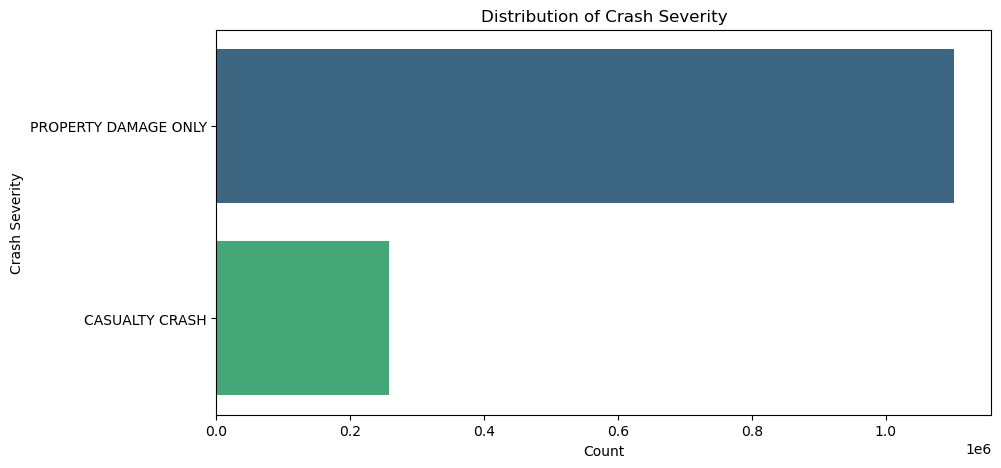

/var/folders/68/tc5j7wv53tb27h1pw_8xhkdr0000gn/T/ipykernel_14680/2485862627.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pdf['Month Of Year'], palette='coolwarm')


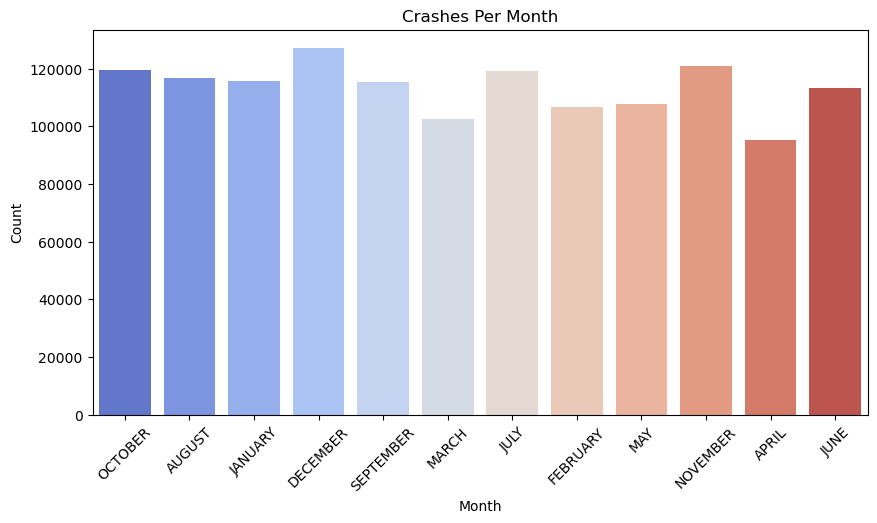

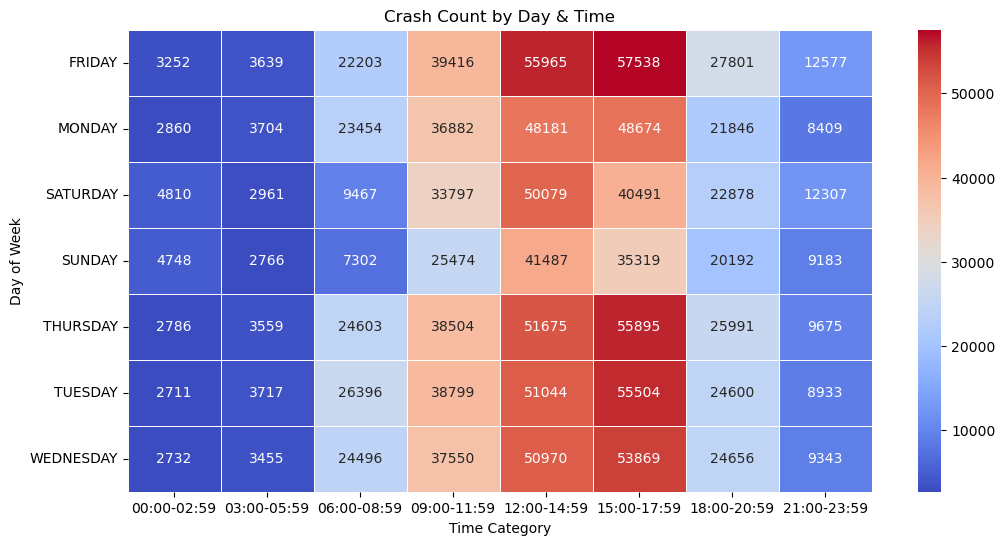

In [6]:

# Call visualization after processing the data
visualize_data(icbc_df)


In [8]:
from pyspark.sql import SparkSession, types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Initialize Spark Session
spark = SparkSession.builder.appName("TAS Data ETL").getOrCreate()

# Define the schema for TAS CSV
tas_schema = StructType([
    StructField("Region", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Accident Type", StringType(), True),
    StructField("Age Range", StringType(), True),
    StructField("Contributing Factor 1", StringType(), True),
    StructField("Contributing Factor 2", StringType(), True),
    StructField("Contributing Factor 3", StringType(), True),
    StructField("Contributing Factor 4", StringType(), True),
    StructField("Crash Configuration", StringType(), True),
    StructField("Entity Type", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Month", StringType(), True),
    StructField("Vehicle Type", StringType(), True),
    StructField("Vehicle Use", StringType(), True),
    StructField("Entity Count", IntegerType(), True),
    StructField("Collision Type", StringType(), True),
    StructField("Damage Location", StringType(), True),
    StructField("Damage Severity", StringType(), True),
    StructField("Driver License Jurisdiction", StringType(), True),
    StructField("Pre Action", StringType(), True),
    StructField("Travel Direction", StringType(), True),
    StructField("Vehicle Body Style", StringType(), True),
    StructField("Vehicle Jurisdiction", StringType(), True),
    StructField("Vehicle Make", StringType(), True),
    StructField("Vehicle Model Year", IntegerType(), True)
])

# Define the file path
tas_path = "TAS_entity.csv"

# Read the TAS CSV file
tas_df = spark.read.option("header", True) \
                   .option("sep", "\t") \
                   .option("encoding", "UTF-16") \
                   .csv(tas_path, schema=tas_schema)

# Show the first few rows
tas_df.show(5)

+--------------+----+--------------------+---------+---------------------+---------------------+---------------------+---------------------+--------------------+-----------+------+---------+--------------------+-----------------+------------+-------------------+---------------+---------------+---------------------------+--------------------+----------------+-------------------+--------------------+------------+------------------+
|        Region|Year|       Accident Type|Age Range|Contributing Factor 1|Contributing Factor 2|Contributing Factor 3|Contributing Factor 4| Crash Configuration|Entity Type|Gender|    Month|        Vehicle Type|      Vehicle Use|Entity Count|     Collision Type|Damage Location|Damage Severity|Driver License Jurisdiction|          Pre Action|Travel Direction| Vehicle Body Style|Vehicle Jurisdiction|Vehicle Make|Vehicle Model Year|
+--------------+----+--------------------+---------+---------------------+---------------------+---------------------+--------------

In [10]:
tas_pd = tas_df.toPandas()

In [15]:
icbc_pd = icbc_df.toPandas()

VISUALIZATION 1 - Accidents by Year

/var/folders/68/tc5j7wv53tb27h1pw_8xhkdr0000gn/T/ipykernel_27056/3784594244.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=tas_pd, x="Year", palette="coolwarm")


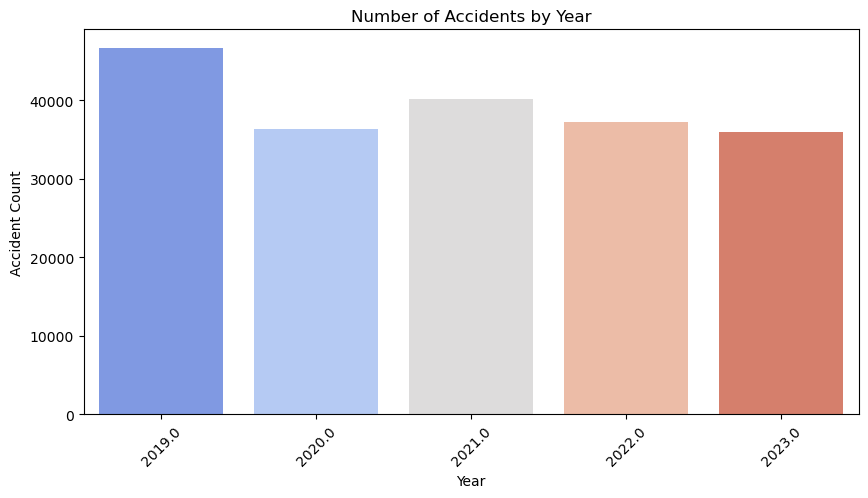

In [11]:
plt.figure(figsize=(10, 5))
sns.countplot(data=tas_pd, x="Year", palette="coolwarm")
plt.title("Number of Accidents by Year")
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Accident Count")
plt.show()

VISUALIZATION 2 -  Distribution of Accident Types

/var/folders/68/tc5j7wv53tb27h1pw_8xhkdr0000gn/T/ipykernel_27056/4096443693.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=tas_pd, y="Accident Type", order=tas_pd["Accident Type"].value_counts().index, palette="viridis")


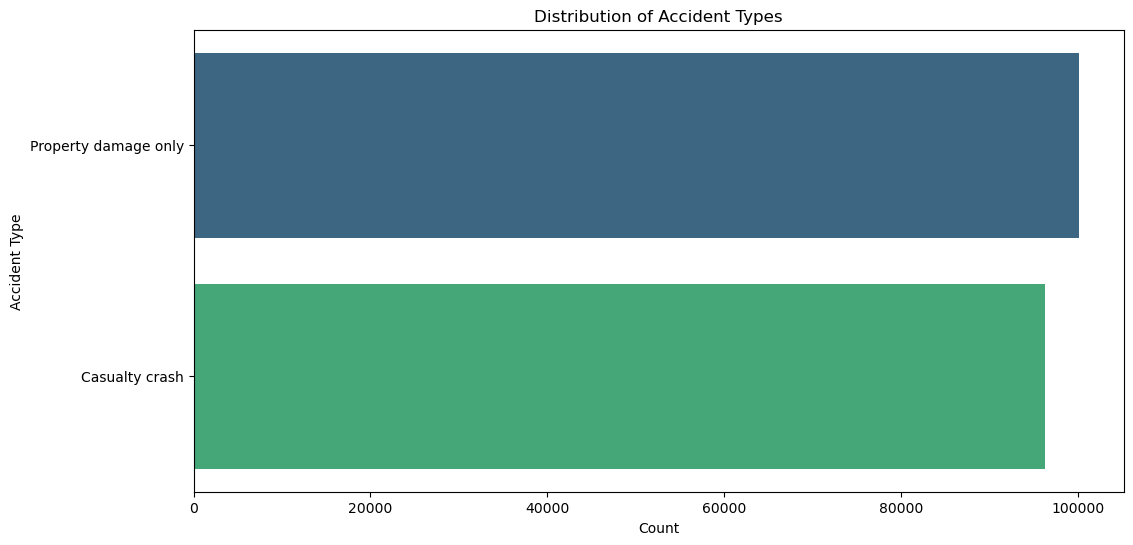

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=tas_pd, y="Accident Type", order=tas_pd["Accident Type"].value_counts().index, palette="viridis")
plt.title("Distribution of Accident Types")
plt.xlabel("Count")
plt.ylabel("Accident Type")
plt.show()

VISUALIZATION 3 - Accidents by Vehicle Type

/var/folders/68/tc5j7wv53tb27h1pw_8xhkdr0000gn/T/ipykernel_27056/1620958806.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=tas_pd, y="Vehicle Type", order=tas_pd["Vehicle Type"].value_counts().index, palette="muted")


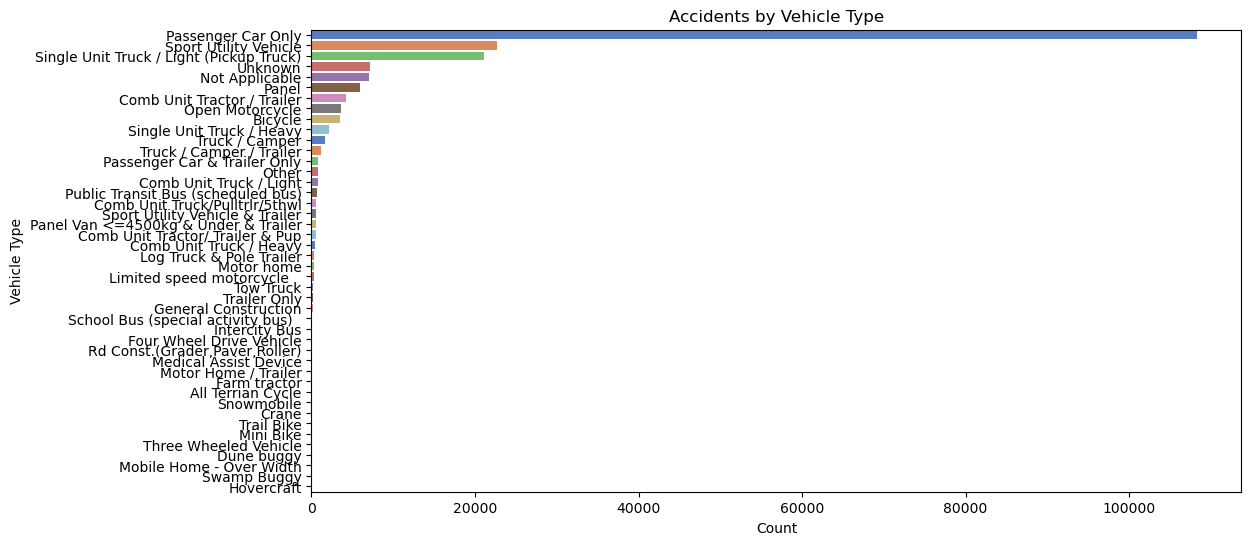

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(data=tas_pd, y="Vehicle Type", order=tas_pd["Vehicle Type"].value_counts().index, palette="muted")
plt.title("Accidents by Vehicle Type")
plt.xlabel("Count")
plt.ylabel("Vehicle Type")
plt.show()

VISUALIZATION 4 - CORRELATION HEATMAP

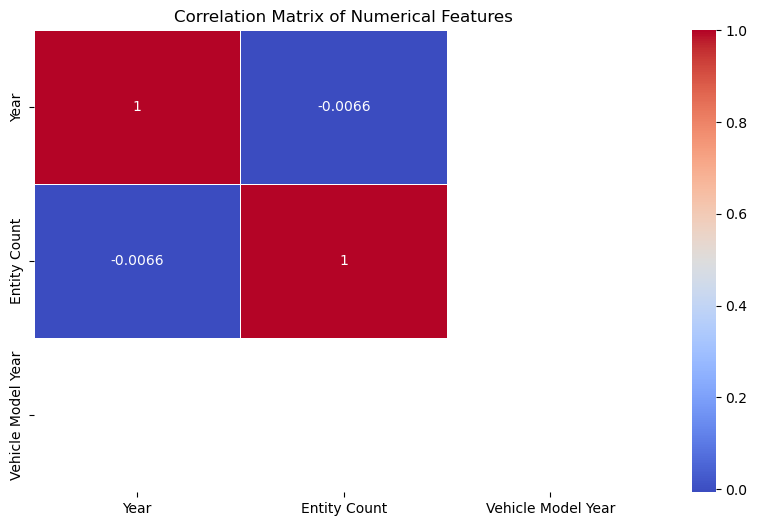

In [14]:
tas_pd_numeric = tas_pd.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(10, 6))
sns.heatmap(tas_pd_numeric.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [8]:
from pyspark.sql.functions import upper

# Rename columns in icbc_df to match tas_df
icbc_df = icbc_df.withColumnRenamed("Date Of Loss Year", "Year") \
                 .withColumnRenamed("Month Of Year", "Month")

# Convert "Month" and "Region" to uppercase for consistency
icbc_df = icbc_df.withColumn("Month", upper(icbc_df["Month"]))
tas_df = tas_df.withColumn("Month", upper(tas_df["Month"]))
icbc_df = icbc_df.withColumn("Region", upper(icbc_df["Region"]))
tas_df = tas_df.withColumn("Region", upper(tas_df["Region"]))


In [9]:
merged_df = icbc_df.join(tas_df, on=["Year", "Region", "Month"], how="inner")

# Show the merged dataset
merged_df.show(5)

25/03/04 11:37:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-------------+------+--------------+-----------+---------------------------+------------------+-------------------------+-------------+-----------------+-------------------------+----------------+-------------+-------------+--------+----------------------+---------+---------------+------------+--------------------+---------+---------------------+---------------------+---------------------+---------------------+--------------------+-----------+------+--------------------+-----------------+------------+--------------+----------------+--------------------+---------------------------+--------------------+----------------+-------------------+--------------------+------------+------------------+
|Year|       Region| Month|Crash Severity|Day Of Week|Derived Crash Configuration|Intersection Crash|Street Full Name (ifnull)|Time Category|Municipality Name|Road Location Description|Street Full Name|Total Crashes|Total Victims|Latitude|Cross Street Full Name|Longitude|Mid Block Crash|is_dupl